## Label recognition computer vision
### Enzyme Advising Group

In [1]:
import pyttsx3
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
import imutils
import numpy

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe" 

In [2]:
IMG_DIR = 'images/'

### Preprocessing of images using OpenCV

We will write basic functions for different preprocessing methods 
- grayscaling
- thresholding
- dilating
- eroding
- opening
- canny edge detection
- noise removal
- deskwing
- template matching. 

Different methods can come in handy with different kinds of images. 

In [3]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

def display(img, frameName):
    if not debug:
        return
    h, w = img.shape[0:2]
    neww = 800
    newh = int(neww*(h/w))
    img = cv2.resize(img, (neww, newh))
    plt.imshow(img)
    plt.title(frameName)
    plt.show()
    
def rotate(img, theta):
    rows, cols = img.shape[0], img.shape[1]
    image_center = (cols/2, rows/2)

    M = cv2.getRotationMatrix2D(image_center,theta,1)

    abs_cos = abs(M[0,0])
    abs_sin = abs(M[0,1])

    bound_w = int(rows * abs_sin + cols * abs_cos)
    bound_h = int(rows * abs_cos + cols * abs_sin)

    M[0, 2] += bound_w/2 - image_center[0]
    M[1, 2] += bound_h/2 - image_center[1]

    # rotate orignal image to show transformation
    rotated = cv2.warpAffine(img,M,(bound_w,bound_h),borderValue=(255,255,255))
    return rotated

def slope(x1, y1, x2, y2):
    if x1 == x2:
        return 0
    slope = (y2-y1)/(x2-x1)
    theta = np.rad2deg(np.arctan(slope))
    return theta


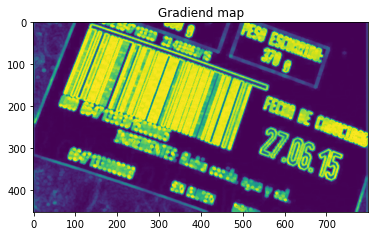

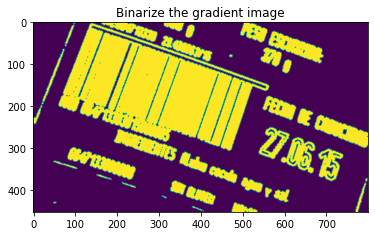

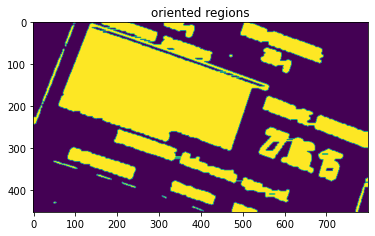

Image orientation in degress:  18.433798558582705


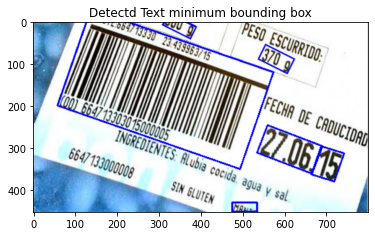

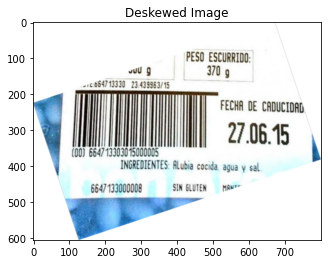

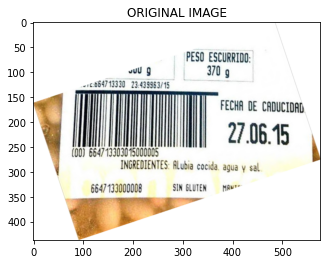

In [4]:
debug = True

# Plot original image
ori_image = cv2.imread(IMG_DIR + 'expiration_date_rotate.jpg')

textImg = ori_image.copy()
small = cv2.cvtColor(textImg, cv2.COLOR_BGR2GRAY)

#find the gradient map
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

display(grad, 'Gradiend map')

#Binarize the gradient image
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
display(bw, 'Binarize the gradient image')

#connect horizontally oriented regions
#kernal value (9,1) can be changed to improved the text detection
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
display(connected, 'oriented regions')

# using RETR_EXTERNAL instead of RETR_CCOMP
_ , contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

mask = np.zeros(bw.shape, dtype=np.uint8)
#display(mask)
#cumulative theta value
cummTheta = 0
#number of detected text regions
ct = 0

for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    #fill the contour
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    #display(mask)
    #ratio of non-zero pixels in the filled region
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

    #assume at least 45% of the area is filled if it contains text
    if r > 0.45 and w > 8 and h > 8:
        #cv2.rectangle(textImg, (x1, y), (x+w-1, y+h-1), (0, 255, 0), 2)
        rect = cv2.minAreaRect(contours[idx])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(textImg,[box],0,(0,0,255),2)

        #we can filter theta as outlier based on other theta values
        #this will help in excluding the rare text region with different orientation from ususla value
        theta = slope(box[0][0], box[0][1], box[1][0], box[1][1])
        cummTheta += theta
        ct +=1
        #print("Theta", theta)

#find the average of all cumulative theta value
orientation = cummTheta/ct
print("Image orientation in degress: ", orientation)
image = rotate(ori_image, orientation)
display(textImg, "Detectd Text minimum bounding box")
display(image, "Deskewed Image")

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('ORIGINAL IMAGE')
plt.show()

In [5]:
# Preprocess image 
gray = get_grayscale(image)
thresh_img = thresholding(gray)
opening_img = opening(gray)
canny_img = canny(gray)
images = {'gray': gray, 
          'thresh': thresh_img, 
          'opening': opening_img, 
          'canny': canny_img}

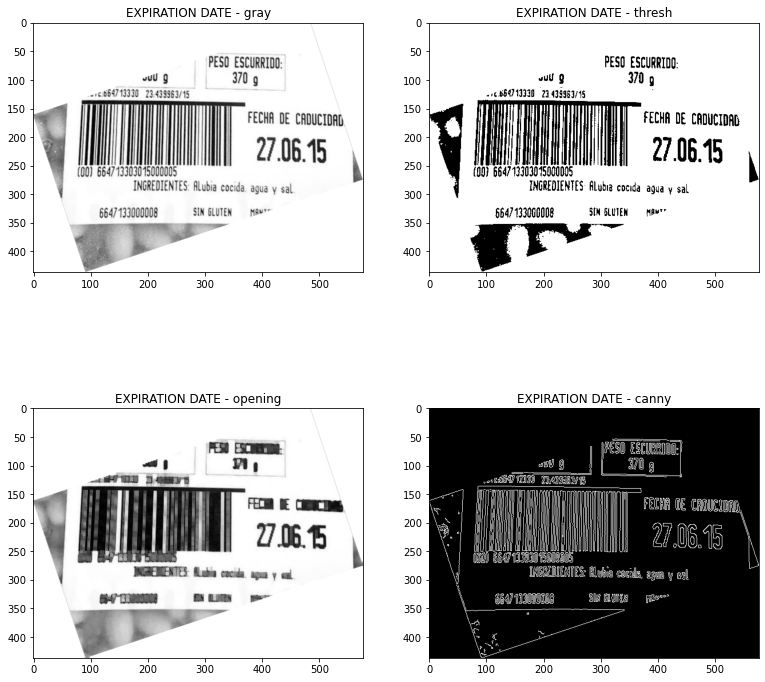

In [6]:
# Plot images after preprocessing
fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('EXPIRATION DATE - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')    

In [7]:
# Get OCR output using Pytesseract
custom_config = r'--psm 11 outputbase digits'

print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
lines_original = pytesseract.image_to_string(image, config=custom_config)
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(thresh_img, config=custom_config))
lines_threshold = pytesseract.image_to_string(thresh_img, config=custom_config)
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(opening_img, config=custom_config))
lines_opening = pytesseract.image_to_string(opening_img, config=custom_config)
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(canny_img, config=custom_config))
lines_canny = pytesseract.image_to_string(canny_img, config=custom_config)

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
0

3709

186471333023.43996315

0066471330301500000

27.06.15

..

6647133000008

.

-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
3709

169571933029.439953715

00664713303075000005

27.06.15

.

5

66471

000008

-----------------------------------------
TESSERACT OUTPUT --> OPENED IMAGE
-----------------------------------------
2

2706.6

-----------------------------------------
TESSERACT OUTPUT --> CANNY EDGE IMAGE
-----------------------------------------
0

27.06.65

0


In [8]:
# Extract expiration date
def by_size(words, size):
    return [word for word in words if len(word) == size]


list_original = by_size(lines_original.split(),8)
list_threshold = by_size(lines_threshold.split(),8)
list_opening = by_size(lines_opening.split(),8)
list_canny = by_size(lines_canny.split(),8)

list_expiration_date = [list_original, list_threshold, list_opening, list_canny]
list_expiration_date = [i for i in list_expiration_date if i != []]
list_expiration_date = [list(i) for i in set(map(tuple, list_expiration_date))]

print(list_expiration_date)


[['27.06.15'], ['27.06.65']]


In [9]:
# Text to speech
import pyttsx3
engine = pyttsx3.init()

voices = engine.getProperty('voices')

engine.setProperty('rate', 150)

for voice in voices:
    print("Voice: %s" % voice.name)
    print(" - ID: %s" % voice.id)
    print(" - Languages: %s" % voice.languages)
    print(" - Gender: %s" % voice.gender)
    print(" - Age: %s" % voice.age)
    print("\n")
engine.setProperty("voice", voices[0].id)

text = 'Hola, la fecha de expiración del producto corresponde al dia '
 
for count,ele in enumerate(list_expiration_date):
    if count ==0:
        text = text + str(ele[0])
    else:
        text = text + ' o ' + str(ele[0])    

engine.say(text)
engine.runAndWait()

Voice: Microsoft Helena Desktop - Spanish (Spain)
 - ID: HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Speech\Voices\Tokens\TTS_MS_ES-ES_HELENA_11.0
 - Languages: []
 - Gender: None
 - Age: None


Voice: Microsoft Zira Desktop - English (United States)
 - ID: HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Speech\Voices\Tokens\TTS_MS_EN-US_ZIRA_11.0
 - Languages: []
 - Gender: None
 - Age: None




### Bounding box information using Pytesseract

While running and image through the tesseract OCR engine, pytesseract allows you to get bounding box imformation 
- on a character level
- on a word level
- based on a regex template

We will see how to obtain both

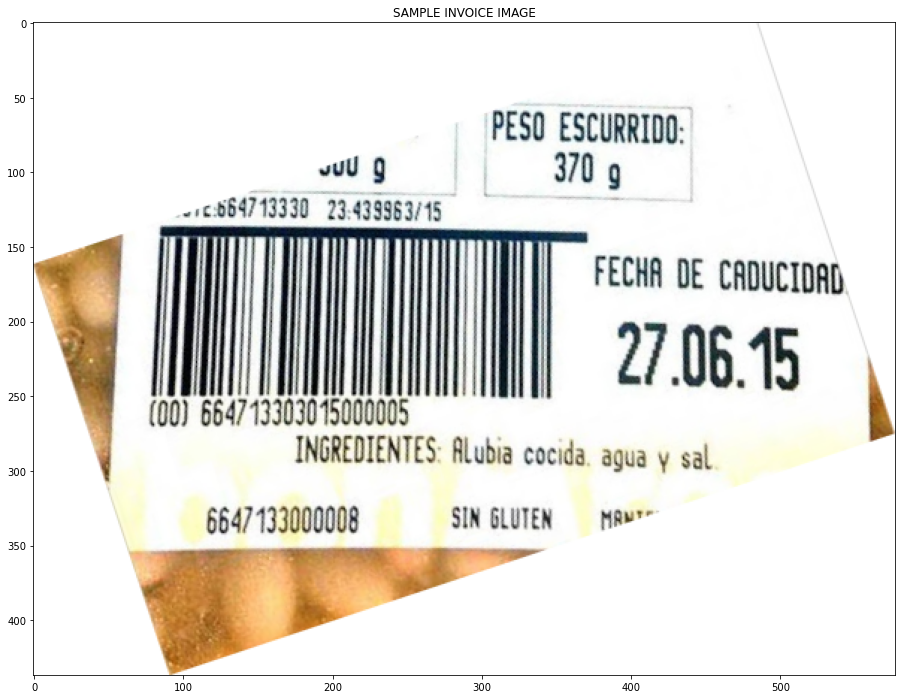

In [10]:
# Plot original image with rotation
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE IMAGE')
plt.show()

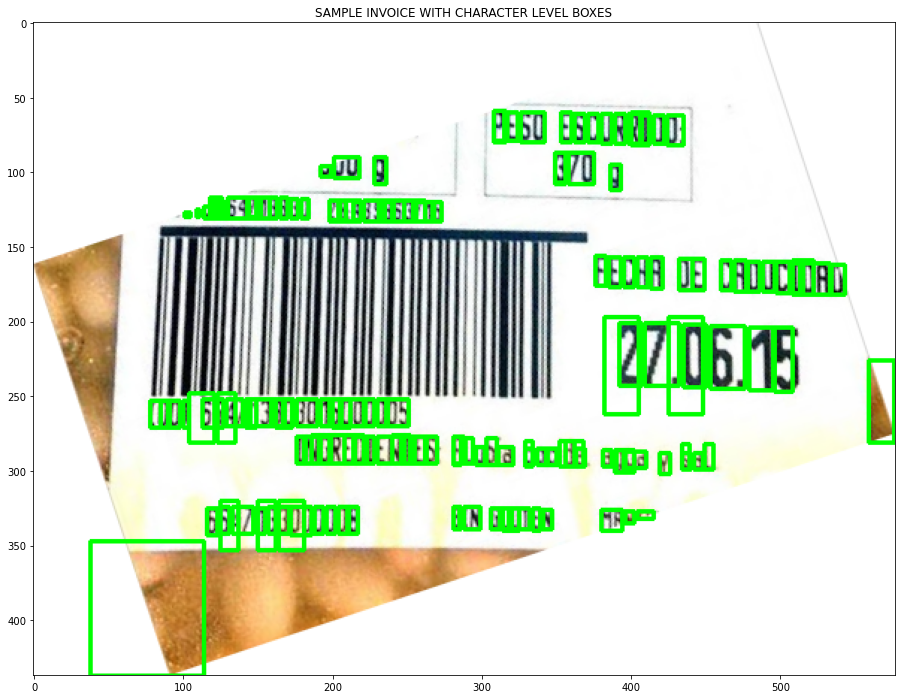

In [11]:
# Plot character boxes on image using pytesseract.image_to_boxes() function
h, w, c = image.shape
boxes = pytesseract.image_to_boxes(image) 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


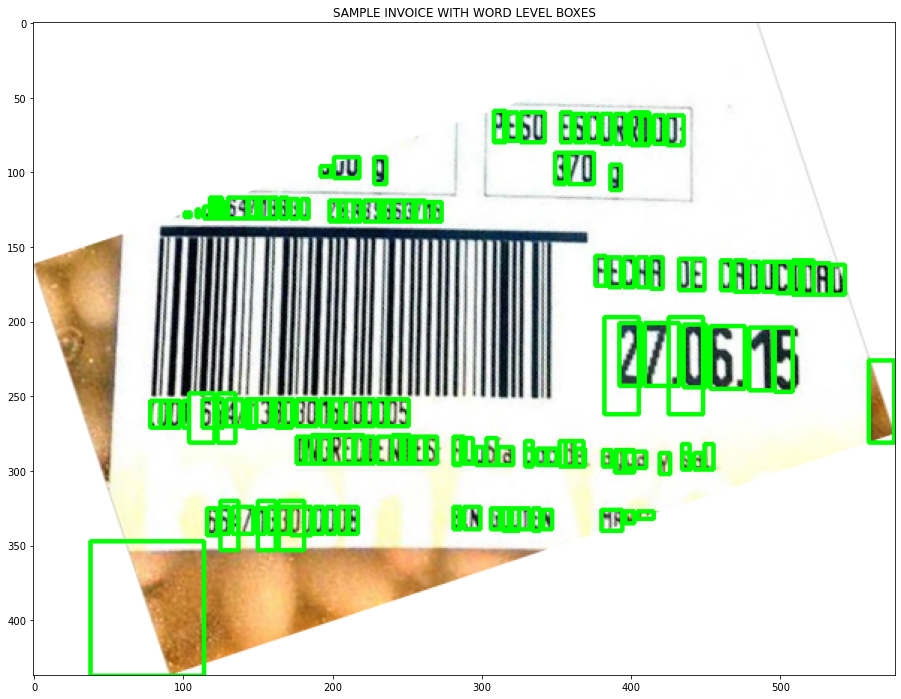

In [12]:
# Plot word boxes on image using pytesseract.image_to_data() function
d = pytesseract.image_to_data(image, output_type=Output.DICT)
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH WORD LEVEL BOXES')
plt.show()

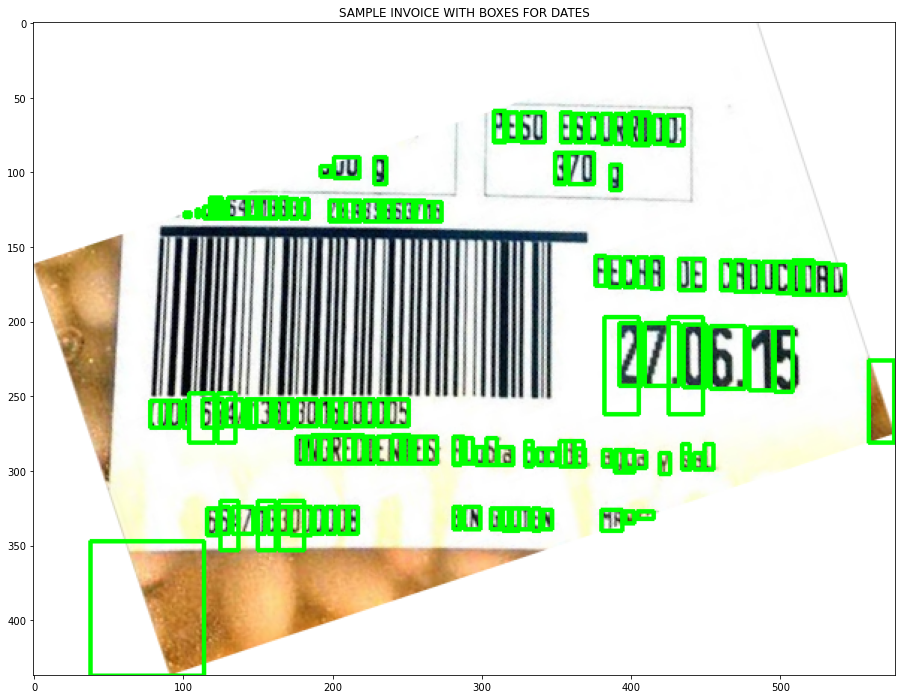

In [13]:
# Plot boxes around text that matches a certain regex template
# In this example we will extract the date from the sample invoice
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        if re.match(date_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH BOXES FOR DATES')
plt.show()